# **Advanced Hyperparameter Optimization**

## Mục tiêu
- Sử dụng Optuna để tối ưu hyperparameters cho XGBoost, Random Forest, và Gradient Boosting
- Target: Test MAE < 1.0°C
- Sử dụng TimeSeriesSplit với 5-fold CV để đánh giá
- So sánh performance trước và sau optimization


In [162]:
import os
import sys
import random
import warnings
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib
# matplotlib.use("Agg")  # uncomment nếu chạy headless/CI
import matplotlib.pyplot as plt

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Core ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# Boosting libs
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
import lightgbm as lgb

# HPO
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Your utilities
from src.utils.performance_monitor import timed_mem_call
from src.utils.scores import _regression_scores 
from src.utils.rolling_origin_cv import RollingOriginTimeSeriesSplit

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ.setdefault('OMP_NUM_THREADS', '4')
os.environ.setdefault('MKL_NUM_THREADS', '4')
os.environ.setdefault('NUMEXPR_NUM_THREADS', '4')
np.random.seed(SEED)
random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Warnings (có chủ đích)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

print(f"Seed: {SEED}")
performance_stats = {}
print("Performance monitoring")

try:
    import sklearn, xgboost, lightgbm
    print(
        "Versions -> "
        f"sklearn: {sklearn.__version__} | "
        f"xgboost: {xgboost.__version__} | "
        f"lightgbm: {lightgbm.__version__} | "
        f"optuna: {optuna.__version__}"
    )
except Exception:
    pass


Seed: 42
Performance monitoring
Versions -> sklearn: 1.7.0 | xgboost: 3.0.5 | lightgbm: 4.6.0 | optuna: 4.5.0


# 1. Load Best Performance Dataset

In [164]:
def load_split(file_path, schema_json=None):
    file_path = Path(file_path)
    df = pd.read_csv(file_path, parse_dates=['datetime'])

    y = df['target']
    groups = df['datetime']   

    drop_cols = [c for c in ['target', 'datetime', 'name'] if c in df.columns]
    X = df.drop(columns=drop_cols)

    if schema_json is not None:
        cols = pd.read_json(schema_json, typ='series')
        cols = list(cols.values) if isinstance(cols, pd.Series) else list(cols)
        X = X.reindex(columns=cols)

    print(f"[{file_path.name}] df={df.shape}, X={X.shape}, y={y.shape}")
    print(f"    min/max date: {groups.min().date()} -> {groups.max().date()}\n")
    return X, y, groups, df

# dùng bộ FE+DT
X_train, y_train, g_train, df_train = load_split(
    '../data/splits/fe_dt_train.csv',
    schema_json='../data/splits/fe_dt_selected_columns.json'
)
X_val,   y_val,   g_val,   df_val   = load_split(
    '../data/splits/fe_dt_val.csv',
    schema_json='../data/splits/fe_dt_selected_columns.json'
)
X_test,  y_test,  g_test,  df_test  = load_split(
    '../data/splits/fe_dt_test.csv',
    schema_json='../data/splits/fe_dt_selected_columns.json'
)

[fe_dt_train.csv] df=(59058, 29), X=(59058, 26), y=(59058,)
    min/max date: 2015-01-08 -> 2024-01-01

[fe_dt_val.csv] df=(3150, 29), X=(3150, 26), y=(3150,)
    min/max date: 2024-02-08 -> 2024-07-31

[fe_dt_test.csv] df=(6444, 29), X=(6444, 26), y=(6444,)
    min/max date: 2024-09-07 -> 2025-08-30



# 2. Utility Function

In [ ]:
ES_ROUNDS = 100
ES_METRIC = "mae"  # dùng cho xgb/lgb/hgb

def rolling_cv_score_with_es(
    model_name,
    params,
    X, y, groups,
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
):
    """
    CV theo datetime thực tế (rolling-origin).
    Trả về: mean_mae (float), median_best_iter (int hoặc None)
    """
    ro_cv = RollingOriginTimeSeriesSplit(
        date_col=None,              # groups đã được truyền rồi
        min_train_days=min_train_days,
        step_days=step_days,
        horizon_days=horizon_days,
        gap_days=gap_days,
        max_splits=max_splits,
    )

    maes = []
    best_iters = []

    # quan trọng: dùng X=None, groups=groups để cắt theo ngày
    for tr_idx, va_idx in ro_cv.split(X=None, groups=groups):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        if model_name == 'xgb':
            mdl = XGBRegressor(
                **params,
                random_state=SEED,
                n_jobs=-1,
                tree_method='hist',
                verbosity=0,
                eval_metric=ES_METRIC,
                early_stopping_rounds=ES_ROUNDS,
            )
            mdl.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                verbose=False,
            )
            y_hat = mdl.predict(X_va)
            best_iters.append(
                getattr(mdl, "best_iteration", getattr(mdl, "best_ntree_limit", None))
            )

        elif model_name == 'lgb':
            from lightgbm import early_stopping
            mdl = LGBMRegressor(
                **params,
                random_state=SEED,
                n_jobs=-1,
                verbose=-1,
            )
            mdl.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric=ES_METRIC,
                callbacks=[early_stopping(stopping_rounds=ES_ROUNDS, verbose=False)]
            )
            y_hat = mdl.predict(X_va)
            best_iters.append(getattr(mdl, "best_iteration_", None))

        elif model_name == 'rf':
            mdl = RandomForestRegressor(
                **params,
                random_state=SEED,
                n_jobs=-1,
            )
            mdl.fit(X_tr, y_tr)
            y_hat = mdl.predict(X_va)

        elif model_name == 'gb':
            mdl = GradientBoostingRegressor(
                **params,
                random_state=SEED,
            )
            mdl.fit(X_tr, y_tr)
            y_hat = mdl.predict(X_va)
        
        elif model_name == 'hgb':
            mdl = HistGradientBoostingRegressor(**params)
            mdl.fit(X_tr, y_tr)            # early_stopping nội bộ dùng 10% của X_tr
            y_hat = mdl.predict(X_va)

        else:
            raise ValueError(f"Unknown model_name: {model_name}")

        mae, _, _ = _regression_scores(y_va, y_hat)
        maes.append(mae)

    mean_mae = float(np.mean(maes))
    # median best_iter cho xgb/lgb
    valid_bi = [b for b in best_iters if b is not None]
    median_best_iter = int(np.median(valid_bi)) if valid_bi else None
    return mean_mae, median_best_iter

# 3. XGBoost Hyperparameter Optimization

In [11]:
print("XGBOOST HPO (Rolling-Origin)")

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    # CV theo rolling-origin, dùng datetime của train
    mean_mae, median_best_iter = rolling_cv_score_with_es(
        'xgb', params,
        X_train, y_train, g_train,
        min_train_days=365*5,
        step_days=30,
        horizon_days=7,
        gap_days=30,
        max_splits=None,
    )
    trial.set_user_attr("mean_mae", mean_mae)
    if median_best_iter is not None:
        trial.set_user_attr("median_best_iter", median_best_iter)
    return mean_mae


# đảm bảo có dict để lưu
performance_stats = {}

xgb_study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
)

print("Starting XGBoost HPO (100 trials)")

# đo thời gian + RAM cho toàn bộ quá trình HPO
(_, xgb_opt_stats) = timed_mem_call(
    xgb_study.optimize,
    xgb_objective,
    n_trials=100,
    show_progress_bar=True,
    label="XGBoost Optimization"
)
performance_stats['xgb_optimization'] = xgb_opt_stats

print("Best XGBoost parameters:")
for k, v in xgb_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE: {xgb_study.best_value:.4f}°C")

# CV lại 1 lần với params tốt nhất để log thêm time/mem
(xgb_cv_mean, xgb_cv_best_iter), xgb_cv_stats = timed_mem_call(
    rolling_cv_score_with_es,
    'xgb',
    xgb_study.best_params,
    X_train, y_train, g_train,
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    label="XGB best params rolling-CV"
)
performance_stats['xgb_best_cv'] = xgb_cv_stats

print(f"XGB rolling CV MAE: {xgb_cv_mean:.4f}°C")
print(f"XGB median best_iteration_ from rolling CV: {xgb_cv_best_iter}")

XGBOOST HPO (Rolling-Origin)
Starting XGBoost HPO (100 trials)


  0%|          | 0/100 [00:00<?, ?it/s]

[XGBoost Optimization] time=2504.35s | Py-peak=70.8 MB | RSS(before/after/delta)=467.8/2418.7/1950.9 MB
Best XGBoost parameters:
  n_estimators: 2662
  learning_rate: 0.2978846087896864
  max_depth: 3
  min_child_weight: 2
  subsample: 0.716270053839063
  colsample_bytree: 0.9504639751029286
  reg_alpha: 7.463624759928821
  reg_lambda: 4.303576075727973
Best CV MAE: 0.8851°C
[XGB best params rolling-CV] time=9.96s | Py-peak=26.1 MB | RSS(before/after/delta)=2418.7/2422.2/3.5 MB
XGB rolling CV MAE: 0.8851°C
XGB median best_iteration_ from rolling CV: 31


# 4. Random Forest Hyperparameter Optimization

In [12]:
print("RANDOM FOREST HPO (Rolling-Origin)")

def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical(
            'max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7, 0.9]
        ),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    mean_mae, _ = rolling_cv_score_with_es(
        'rf', params,
        X_train, y_train, g_train,      
        min_train_days=365*5,           
        step_days=30,
        horizon_days=7,
        gap_days=30,
        max_splits=None,
    )

    # log lại vào trial để sau này export
    trial.set_user_attr("mean_mae", mean_mae)
    return mean_mae


# đảm bảo có dict chứa stats
performance_stats = performance_stats if 'performance_stats' in globals() else {}

rf_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

print("Starting Random Forest HPO (50 trials)")

# đo thời gian + RAM cho toàn bộ quá trình HPO
(_, rf_opt_stats) = timed_mem_call(
    rf_study.optimize,
    rf_objective,
    n_trials=50,
    show_progress_bar=True,
    label="Random Forest Optimization"
)
performance_stats['rf_optimization'] = rf_opt_stats

print("Best Random Forest parameters:")
for k, v in rf_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE (rolling): {rf_study.best_value:.4f}°C")

# CV lại 1 lần với params tốt nhất để log thêm time/mem
(rf_cv_mean, _), rf_cv_stats = timed_mem_call(
    rolling_cv_score_with_es,
    'rf',
    rf_study.best_params,
    X_train, y_train, g_train,
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    label="RF best params rolling-CV"
)
performance_stats['rf_best_cv'] = rf_cv_stats

print(f"RF rolling CV MAE: {rf_cv_mean:.4f}°C")

RANDOM FOREST HPO (Rolling-Origin)
Starting Random Forest HPO (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

[Random Forest Optimization] time=35206.78s | Py-peak=47.2 MB | RSS(before/after/delta)=2247.9/2436.0/188.1 MB
Best Random Forest parameters:
  n_estimators: 910
  max_depth: 20
  min_samples_split: 14
  min_samples_leaf: 7
  max_features: 0.3
  bootstrap: True
Best CV MAE (rolling): 0.9457°C
[RF best params rolling-CV] time=396.24s | Py-peak=46.1 MB | RSS(before/after/delta)=2436.1/2572.2/136.0 MB
RF rolling CV MAE: 0.9457°C


# 5. Hist Gradient Boosting Hyperparameter Optimization

In [26]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("HIST-GRADIENT BOOSTING HPO (Rolling-Origin)")

def hgb_objective(trial):
    params = {
        "max_iter": trial.suggest_int("max_iter", 100, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 200),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 10.0),
        "max_bins": trial.suggest_int("max_bins", 64, 255),

        # Early stopping (sklearn HGB)
        "early_stopping": True,          # hoặc "auto"
        "n_iter_no_change": 30,
        "validation_fraction": 0.1,
        "tol": 1e-4,
        "random_state": SEED,
    }

    mean_mae, _ = rolling_cv_score_with_es(
        'hgb', params,
        X_train, y_train, g_train,
        min_train_days=365*5, step_days=30, horizon_days=7, gap_days=30
    )
    trial.set_user_attr("mean_mae", mean_mae)
    return mean_mae


performance_stats = performance_stats if 'performance_stats' in globals() else {}

hgb_study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=10)
)
print("Starting Hist-Gradient Boosting HPO (50 trials)")

(_, hgb_opt_stats) = timed_mem_call(
    hgb_study.optimize,
    hgb_objective,
    n_trials=50,
    show_progress_bar=True,
    label="HGB Optimization"
)
performance_stats['hgb_optimization'] = hgb_opt_stats

print("Best Hist-Gradient Boosting parameters:")
for k, v in hgb_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE (rolling): {hgb_study.best_value:.4f}°C")

# Re-check CV với best params
(hgb_cv_mean, _), hgb_cv_stats = timed_mem_call(
    rolling_cv_score_with_es,
    'hgb',
    hgb_study.best_params,
    X_train, y_train, g_train,
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    label="HGB best params rolling-CV"
)
performance_stats['hgb_best_cv'] = hgb_cv_stats

print(f"HGB rolling CV MAE: {hgb_cv_mean:.4f}°C")

HIST-GRADIENT BOOSTING HPO (Rolling-Origin)
Starting Hist-Gradient Boosting HPO (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

[HGB Optimization] time=9833.41s | Py-peak=58.4 MB | RSS(before/after/delta)=1720.3/817.4/-903.0 MB
Best Hist-Gradient Boosting parameters:
  max_iter: 1012
  learning_rate: 0.012125629110754665
  max_depth: 3
  max_leaf_nodes: 198
  min_samples_leaf: 122
  l2_regularization: 6.634064286119825
  max_bins: 207
Best CV MAE (rolling): 0.9379°C
[HGB best params rolling-CV] time=79.39s | Py-peak=31.7 MB | RSS(before/after/delta)=817.7/633.9/-183.7 MB
HGB rolling CV MAE: 0.9384°C


# 6. LightGBM Hyperparameter Optimization

In [14]:
print("LIGHTGBM HYPERPARAMETER HPO (Rolling-Origin)")

def lgb_objective(trial):
    #  sinh hyperparams an toàn cho num_leaves theo max_depth
    max_depth = trial.suggest_int('max_depth', 3, 12)
    max_leaves = min(250, 2**max_depth - 1)
    min_leaves = min(16, max_leaves)              # lower bound hợp lệ
    max_leaves_safe = max(min_leaves, max_leaves) # phòng khi max_leaves < min_leaves

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': max_depth,
        'num_leaves': trial.suggest_int('num_leaves', min_leaves, max_leaves_safe),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }

    mean_mae, median_best_iter = rolling_cv_score_with_es(
        'lgb', params,
        X_train, y_train, g_train,
        min_train_days=365*5,
        step_days=30,
        horizon_days=7,
        gap_days=30,
        max_splits=None,
    )

    # log
    trial.set_user_attr("mean_mae", mean_mae)
    if median_best_iter is not None:
        trial.set_user_attr("median_best_iter", median_best_iter)

    return mean_mae


# đảm bảo có dict chứa stats
performance_stats = performance_stats if 'performance_stats' in globals() else {}

lgb_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

print("Starting LightGBM optimization (80 trials)")

# đo thời gian + RAM cho toàn bộ quá trình HPO
(_, lgb_opt_stats) = timed_mem_call(
    lgb_study.optimize,
    lgb_objective,
    n_trials=80,
    show_progress_bar=True,
    label="LightGBM Optimization"
)
performance_stats['lgb_optimization'] = lgb_opt_stats

print("\nBest LightGBM parameters:")
for k, v in lgb_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE (rolling): {lgb_study.best_value:.4f}°C")

# CV lại với params tốt nhất để log thêm time/mem + best_iter
(lgb_cv_mean, lgb_cv_best_iter), lgb_cv_stats = timed_mem_call(
    rolling_cv_score_with_es,
    'lgb',
    lgb_study.best_params,
    X_train, y_train, g_train,
    min_train_days=365*5,
    step_days=30,
    horizon_days=7,
    gap_days=30,
    max_splits=None,
    label="LGB best params rolling-CV"
)
performance_stats['lgb_best_cv'] = lgb_cv_stats

print(f"LGB rolling CV (recheck) MAE: {lgb_cv_mean:.4f}°C")
print(f"LGB median best_iteration_ from rolling CV: {lgb_cv_best_iter}")

LIGHTGBM HYPERPARAMETER HPO (Rolling-Origin)
Starting LightGBM optimization (80 trials)


  0%|          | 0/80 [00:00<?, ?it/s]

[LightGBM Optimization] time=5565.90s | Py-peak=88.1 MB | RSS(before/after/delta)=993.7/1534.4/540.7 MB

Best LightGBM parameters:
  max_depth: 3
  n_estimators: 2835
  learning_rate: 0.29876946969886
  num_leaves: 7
  min_child_samples: 10
  min_gain_to_split: 0.08387198604409331
  subsample: 0.8811986981784626
  colsample_bytree: 0.8541676815620122
  reg_alpha: 4.92773670239969
  reg_lambda: 6.751376841209982
Best CV MAE (rolling): 0.8873°C
[LGB best params rolling-CV] time=17.52s | Py-peak=26.3 MB | RSS(before/after/delta)=1534.4/1540.0/5.6 MB
LGB rolling CV (recheck) MAE: 0.8873°C
LGB median best_iteration_ from rolling CV: 46


# 7. Model Selection Based on CV Results

In [49]:
def tidy_hpo_table(df):
    rename_map = {"value": "cv_mae", "user_attrs_median_best_iter": "median_best_iter"}
    rename_map = {k:v for k,v in rename_map.items() if k in df.columns}
    df = df.rename(columns=rename_map)
    if "median_best_iter" in df.columns and df["median_best_iter"].isna().all():
        df = df.drop(columns=["median_best_iter"])
    return df

xgb_df = xgb_study.trials_dataframe(attrs=('number','value','params','user_attrs','state')).copy()
rf_df  = rf_study .trials_dataframe(attrs=('number','value','params','user_attrs','state')).copy()
lgb_df = lgb_study.trials_dataframe(attrs=('number','value','params','user_attrs','state')).copy()
hgb_df = hgb_study.trials_dataframe(attrs=('number','value','params','user_attrs','state')).copy()

xgb_df['model'] = 'xgb'; rf_df['model'] = 'rf'; lgb_df['model'] = 'lgb'; hgb_df['model'] = 'hgb'
hpo_all = pd.concat([xgb_df, rf_df, lgb_df, hgb_df], ignore_index=True)

hpo_all = tidy_hpo_table(hpo_all)
hpo_all = hpo_all[hpo_all['state'].astype(str).str.upper().eq('COMPLETE')]
hpo_all = hpo_all.dropna(subset=['cv_mae']).reset_index(drop=True)
display(hpo_all)

best_per_model = (hpo_all.sort_values('cv_mae').groupby('model', as_index=False).first())
if 'median_best_iter' in best_per_model.columns:
    best_per_model['median_best_iter'] = pd.to_numeric(best_per_model['median_best_iter'], errors='coerce')
print("Best per model (CV MAE):")
cols_show = ['model','cv_mae'] + (['median_best_iter'] if 'median_best_iter' in best_per_model.columns else [])
display(best_per_model[cols_show].fillna('—'))

best_overall = best_per_model.nsmallest(1, 'cv_mae')
print("Best overall:")
display(best_overall)


,number,cv_mae,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,...,params_max_features,params_min_samples_leaf,params_min_samples_split,params_min_child_samples,params_min_gain_to_split,params_num_leaves,params_l2_regularization,params_max_bins,params_max_iter,params_max_leaf_nodes
0,0,0.936039,0.662398,0.226482,10,6.0,1249.0,0.580836,8.661761,0.662407,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.895089,0.684936,0.056752,3,10.0,1883.0,1.818250,1.834045,0.932977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.910334,0.655798,0.019947,7,3.0,1052.0,2.921446,3.663618,0.844741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.896475,0.618580,0.088100,4,6.0,1477.0,6.075449,1.705241,0.836966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.931896,0.639069,0.224132,12,9.0,382.0,6.842330,4.401525,0.721846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,45,0.943974,NaN,0.019350,4,NaN,NaN,NaN,NaN,NaN,...,NaN,167.0,NaN,NaN,NaN,NaN,8.699883,179.0,1047.0,82.0
276,46,0.946919,NaN,0.010929,6,NaN,NaN,NaN,NaN,NaN,...,NaN,188.0,NaN,NaN,NaN,NaN,2.357142,206.0,1152.0,25.0
277,47,0.942905,NaN,0.006723,3,NaN,NaN,NaN,NaN,NaN,...,NaN,120.0,NaN,NaN,NaN,NaN,4.586853,223.0,1090.0,243.0
278,48,0.952999,NaN,0.028207,4,NaN,NaN,NaN,NaN,NaN,...,NaN,95.0,NaN,NaN,NaN,NaN,3.261159,255.0,1244.0,206.0


Best per model (CV MAE):


,model,cv_mae,median_best_iter
0,hgb,0.937879,—
1,lgb,0.887260,46.0
2,rf,0.945670,—
3,xgb,0.885093,31.0


Best overall:


,model,number,cv_mae,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,...,params_max_features,params_min_samples_leaf,params_min_samples_split,params_min_child_samples,params_min_gain_to_split,params_num_leaves,params_l2_regularization,params_max_bins,params_max_iter,params_max_leaf_nodes
3,xgb,96,0.885093,0.950464,0.297885,3,2.0,2662.0,7.463625,4.303576,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 8. Final Model Training + Validation and Test

In [50]:
# Train Final Models (Rolling-Origin best_iter-aware)
print("TRAINING FINAL MODELS FOR ALL ALGORITHMS (using TRAIN+VAL)")

# gộp train+val để huấn luyện cuối
X_tv = pd.concat([X_train, X_val], axis=0)
y_tv = pd.concat([y_train, y_val], axis=0)
g_tv = pd.concat([g_train, g_val], axis=0)  # nếu cần theo ngày

print(f"Training all final models on combined train+val data: {X_tv.shape}")

final_models = {}
performance_stats = performance_stats if 'performance_stats' in globals() else {}

# XGBoost
if 'xgb_study' in globals():
    def _train_xgb_final():
        from xgboost import XGBRegressor
        xgb_params = dict(xgb_study.best_params)
        try:
            bi = int(best_per_model.loc[best_per_model.model=='xgb','median_best_iter'].iloc[0])
            if bi > 0: xgb_params['n_estimators'] = bi
        except Exception:
            pass
        xgb_params.update(dict(objective='reg:squarederror', n_jobs=-1, tree_method='hist', verbosity=0, random_state=SEED))
        m = XGBRegressor(**xgb_params); m.fit(X_tv, y_tv, verbose=False); return m
    xgb_final, xgb_train_stats = timed_mem_call(_train_xgb_final, label="XGBoost Final Training")
    final_models['xgb'] = xgb_final; performance_stats['xgb_final_training'] = xgb_train_stats

# LightGBM 
if 'lgb_study' in globals():
    def _train_lgb_final():
        from lightgbm import LGBMRegressor
        lgb_params = dict(lgb_study.best_params)
        try:
            bi = int(best_per_model.loc[best_per_model.model=='lgb','median_best_iter'].iloc[0])
            if bi > 0: lgb_params['n_estimators'] = bi
        except Exception:
            pass
        lgb_params.setdefault('random_state', SEED); lgb_params.setdefault('n_jobs', -1); lgb_params.setdefault('verbosity', -1)
        m = LGBMRegressor(**lgb_params); m.fit(X_tv, y_tv); return m
    lgb_final, lgb_train_stats = timed_mem_call(_train_lgb_final, label="LightGBM Final Training")
    final_models['lgb'] = lgb_final; performance_stats['lgb_final_training'] = lgb_train_stats

# HistGradientBoosting 
if 'hgb_study' in globals():
    def _train_hgb_final():
        from sklearn.ensemble import HistGradientBoostingRegressor
        hgb_params = dict(hgb_study.best_params); hgb_params.setdefault('random_state', SEED)
        m = HistGradientBoostingRegressor(**hgb_params); m.fit(X_tv, y_tv); return m
    hgb_final, hgb_train_stats = timed_mem_call(_train_hgb_final, label="Hist-Gradient Boosting Final Training")
    final_models['hgb'] = hgb_final; performance_stats['hgb_final_training'] = hgb_train_stats

# RandomForest
if 'rf_study' in globals():
    def _train_rf_final():
        from sklearn.ensemble import RandomForestRegressor
        rf_params = dict(rf_study.best_params); rf_params.setdefault('random_state', SEED); rf_params.setdefault('n_jobs', -1)
        m = RandomForestRegressor(**rf_params); m.fit(X_tv, y_tv); return m
    rf_final, rf_train_stats = timed_mem_call(_train_rf_final, label="Random Forest Final Training")
    final_models['rf'] = rf_final; performance_stats['rf_final_training'] = rf_train_stats

print(f"Models trained: {list(final_models.keys())}")

TRAINING FINAL MODELS FOR ALL ALGORITHMS (using TRAIN+VAL)
Training all final models on combined train+val data: (62208, 26)
[XGBoost Final Training] time=0.06s | Py-peak=0.3 MB | RSS(before/after/delta)=1489.5/1493.1/3.7 MB
[LightGBM Final Training] time=0.11s | Py-peak=1.3 MB | RSS(before/after/delta)=1493.1/1497.8/4.6 MB
[Hist-Gradient Boosting Final Training] time=1.94s | Py-peak=18.8 MB | RSS(before/after/delta)=1497.5/1512.5/15.0 MB
[Random Forest Final Training] time=11.01s | Py-peak=34.2 MB | RSS(before/after/delta)=1512.5/2125.7/613.2 MB
Models trained: ['xgb', 'lgb', 'hgb', 'rf']


In [51]:
# Test All Final Models and Compare Performance
print("TESTING FINAL MODELS")

display_name = {
    'xgb': 'XGBoost',
    'lgb': 'LightGBM',
    'hgb': 'Hist-Gradient Boosting',
    'rf' : 'Random Forest'
}

all_test_results = {}
performance_stats = performance_stats if 'performance_stats' in globals() else {}

for mkey, model in final_models.items():
    mname = display_name.get(mkey, mkey)
    print(f"\nTesting {mname}")

    def _test_once():
        yhat = model.predict(X_test)
        mae, rmse, r2 = _regression_scores(y_test, yhat)
        # trả về Series để align index khi ghép sidecar
        return pd.Series(yhat, index=y_test.index, name=mkey), float(mae), float(rmse), float(r2)

    (yhat_series, test_mae, test_rmse, test_r2), test_stats = timed_mem_call(
        _test_once, label=f"{mname} Test Evaluation"
    )

    all_test_results[mkey] = {
        'test_mae':  test_mae,
        'test_rmse': test_rmse,
        'test_r2':   test_r2,
        'pred':      yhat_series
    }
    performance_stats[f'{mkey}_test'] = test_stats

    print(f"  Test MAE : {test_mae:.4f}°C")
    print(f"  Test RMSE: {test_rmse:.4f}°C")
    print(f"  Test R²  : {test_r2:.4f}")

# Bảng so sánh kết quả Test (MAE tăng dần)
results_comparison = (
    pd.DataFrame({
        display_name.get(k, k): {
            'Test MAE':  v['test_mae'],
            'Test RMSE': v['test_rmse'],
            'Test R²':   v['test_r2'],
        } for k, v in all_test_results.items()
    }).T
    .sort_values('Test MAE')
)
print("Test comparison (sorted by MAE)")
display(results_comparison.round(4))

# Model tốt nhất trên Test
best_model_disp = results_comparison.index[0]
best_test_mae   = results_comparison.iloc[0]['Test MAE']
print("BEST PERFORMING MODEL ON TEST SET:")
print(f"  Model   : {best_model_disp}")
print(f"  Test MAE: {best_test_mae:.4f}°C")

# Lưu prediction của model tốt nhất (ghép sidecar để phân rã lỗi)
inv_disp = {v: k for k, v in display_name.items()}
best_key = inv_disp.get(best_model_disp, best_model_disp)

df_test_out = df_test[['name', 'datetime', 'target']].copy()
df_test_out['pred']    = all_test_results[best_key]['pred'].values
df_test_out['abs_err'] = (df_test_out['target'] - df_test_out['pred']).abs()

out_dir = Path("../results"); out_dir.mkdir(parents=True, exist_ok=True)
results_comparison.to_csv(out_dir / "test_results_comparison.csv")
df_test_out.to_csv(out_dir / "test_predictions_best_model.csv", index=False)

TESTING FINAL MODELS

Testing XGBoost
[XGBoost Test Evaluation] time=0.00s | Py-peak=0.2 MB | RSS(before/after/delta)=2125.7/2125.7/0.0 MB
  Test MAE : 0.9986°C
  Test RMSE: 1.3061°C
  Test R²  : 0.5929

Testing LightGBM
[LightGBM Test Evaluation] time=0.00s | Py-peak=0.2 MB | RSS(before/after/delta)=2125.7/2125.7/0.0 MB
  Test MAE : 0.9938°C
  Test RMSE: 1.2976°C
  Test R²  : 0.5981

Testing Hist-Gradient Boosting
[Hist-Gradient Boosting Test Evaluation] time=0.04s | Py-peak=0.2 MB | RSS(before/after/delta)=2125.7/2125.7/0.0 MB
  Test MAE : 0.9896°C
  Test RMSE: 1.2887°C
  Test R²  : 0.6036

Testing Random Forest
[Random Forest Test Evaluation] time=0.14s | Py-peak=2.0 MB | RSS(before/after/delta)=2125.7/2125.9/0.2 MB
  Test MAE : 0.9815°C
  Test RMSE: 1.2761°C
  Test R²  : 0.6113
Test comparison (sorted by MAE)


,Test MAE,Test RMSE,Test R²
Random Forest,0.9815,1.2761,0.6113
Hist-Gradient Boosting,0.9896,1.2887,0.6036
LightGBM,0.9938,1.2976,0.5981
XGBoost,0.9986,1.3061,0.5929


BEST PERFORMING MODEL ON TEST SET:
  Model   : Random Forest
  Test MAE: 0.9815°C


# 9. Optimization Diagnostics

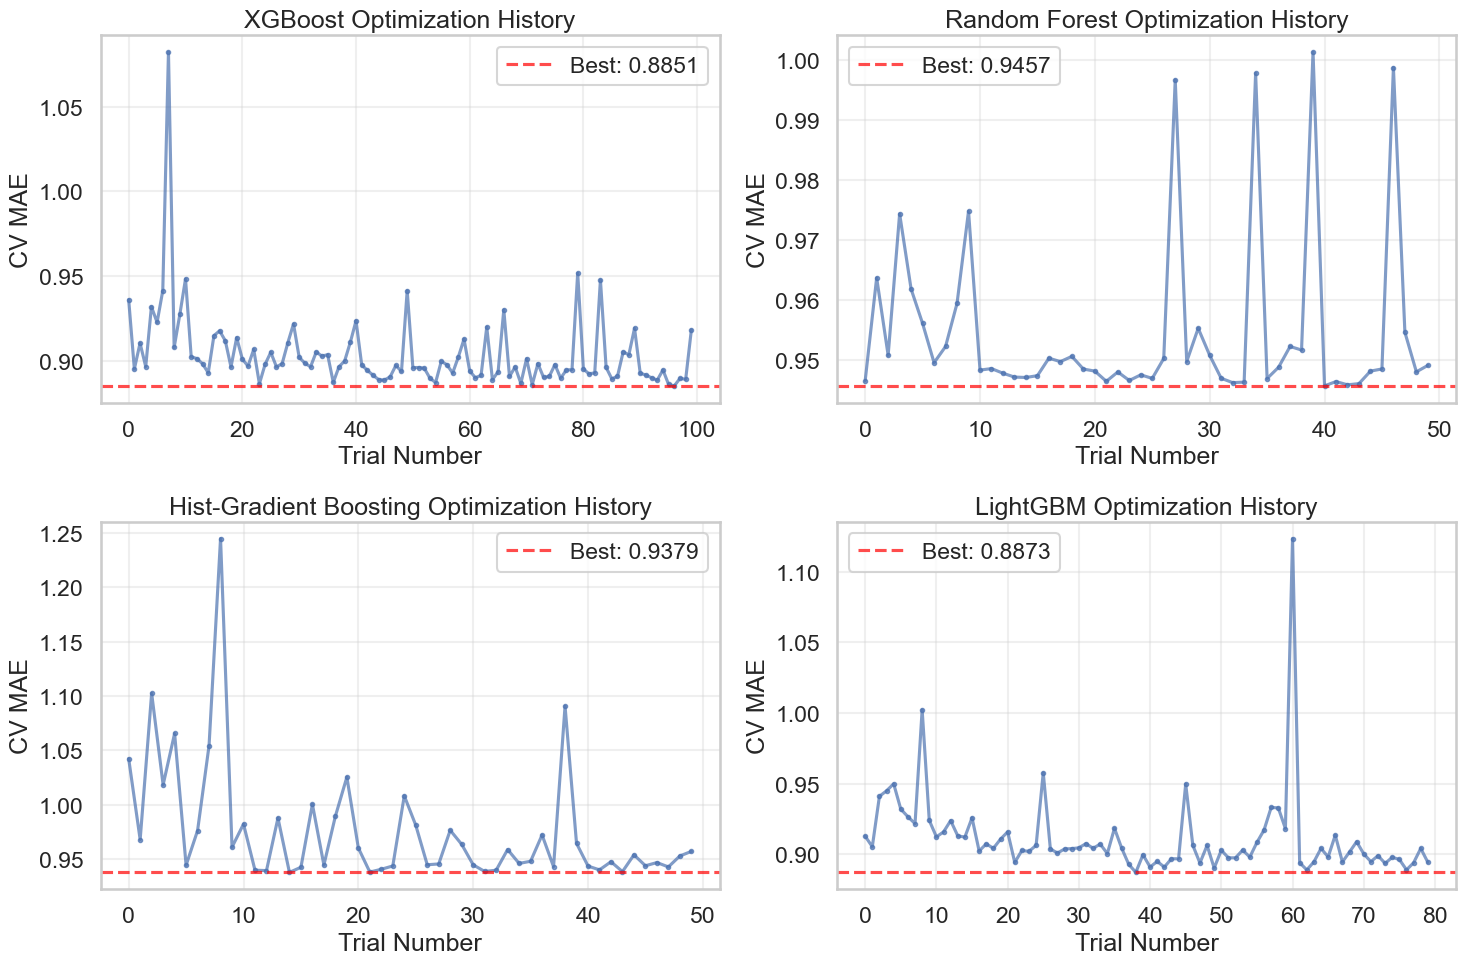

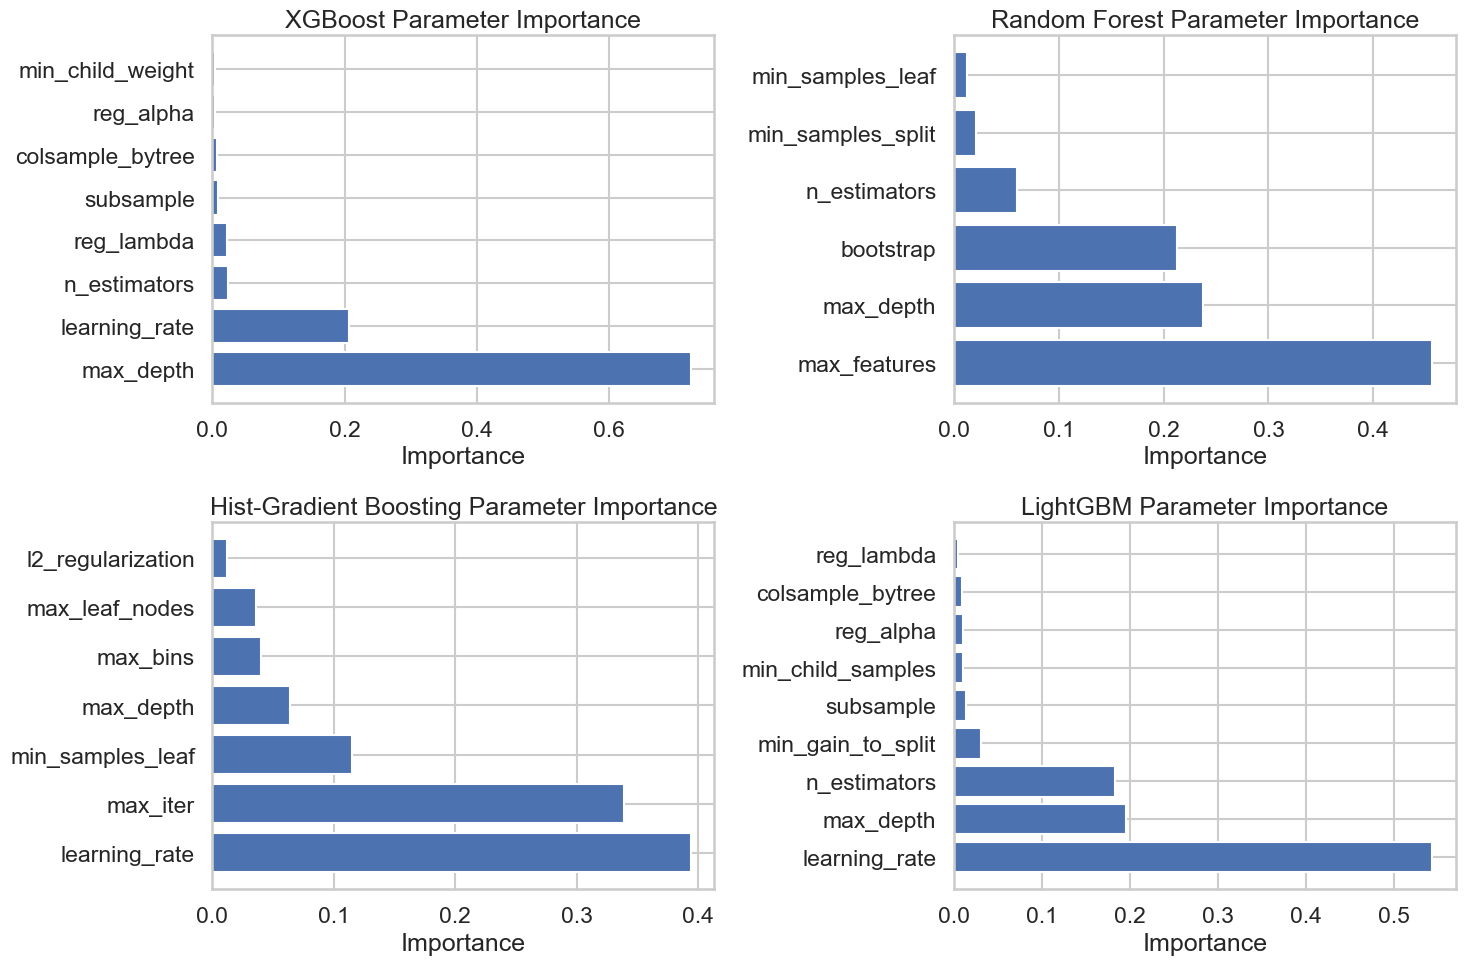

In [53]:
import optuna.visualization as vis

# Create optimization history plots
studies = {
    'XGBoost': xgb_study,
    'Random Forest': rf_study, 
    'Hist-Gradient Boosting': hgb_study,
    'LightGBM': lgb_study
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, study) in enumerate(studies.items()):
    # Optimization history
    trials = study.trials
    trial_numbers = [t.number for t in trials]
    values = [t.value for t in trials if t.value is not None]
    trial_nums = [t.number for t in trials if t.value is not None]
    
    axes[i].plot(trial_nums, values, 'o-', alpha=0.7, markersize=3)
    axes[i].axhline(y=study.best_value, color='red', linestyle='--', alpha=0.7, label=f'Best: {study.best_value:.4f}')
    axes[i].set_title(f'{name} Optimization History')
    axes[i].set_xlabel('Trial Number')
    axes[i].set_ylabel('CV MAE')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Parameter importance plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, study) in enumerate(studies.items()):
    try:
        importance = optuna.importance.get_param_importances(study)
        if importance:
            params = list(importance.keys())
            importances = list(importance.values())
            
            axes[i].barh(params, importances)
            axes[i].set_title(f'{name} Parameter Importance')
            axes[i].set_xlabel('Importance')
        else:
            axes[i].text(0.5, 0.5, 'No importance data', ha='center', va='center')
            axes[i].set_title(f'{name} Parameter Importance')
    except:
        axes[i].text(0.5, 0.5, 'Could not compute importance', ha='center', va='center')
        axes[i].set_title(f'{name} Parameter Importance')

plt.tight_layout()
plt.show()


# 10. Compare with Baseline

In [91]:
print("TRAINING BASELINE MODELS")
print(f"Training on combined train+val data: {X_tv.shape}")

baseline_models = {}
baseline_results = {}
performance_stats = performance_stats if 'performance_stats' in globals() else {}

# Baseline XGBoost
best_iter = 500
xgb_base = XGBRegressor(
    random_state=SEED, n_jobs=-1, verbosity=0,
    objective='reg:squarederror', tree_method='hist',
    n_estimators=best_iter,
    learning_rate=0.08, max_depth=4,
    min_child_weight=1.0, subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, reg_alpha=0.0
)
xgb_base.fit(X_tv, y_tv)
yhat_xgb = xgb_base.predict(X_test)
b_xgb_mae, b_xgb_rmse, b_xgb_r2 = _regression_scores(y_test, yhat_xgb)
baseline_models['xgb'] = xgb_base
baseline_results['XGBoost (Baseline)'] = {
    'test_mae': b_xgb_mae,
    'test_rmse': b_xgb_rmse,
    'test_r2': b_xgb_r2
}
print(f"[Baseline-XGB] MAE={b_xgb_mae:.4f}  RMSE={b_xgb_rmse:.4f}  R²={b_xgb_r2:.4f}")

# Baseline Random Forest
rf_base = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=SEED,
    n_jobs=-1
)
rf_base.fit(X_tv, y_tv)
yhat_rf = rf_base.predict(X_test)
b_rf_mae, b_rf_rmse, b_rf_r2 = _regression_scores(y_test, yhat_rf)
baseline_models['rf'] = rf_base
baseline_results['Random Forest (Baseline)'] = {
    'test_mae': b_rf_mae,
    'test_rmse': b_rf_rmse,
    'test_r2': b_rf_r2
}
print(f"[Baseline-RF] MAE={b_rf_mae:.4f}  RMSE={b_rf_rmse:.4f}  R²={b_rf_r2:.4f}")

# Baseline LightGBM
lgb_base = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.08,
    max_depth=4,
    num_leaves=15,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    verbosity=-1
)
lgb_base.fit(X_tv, y_tv)
yhat_lgb = lgb_base.predict(X_test)
b_lgb_mae, b_lgb_rmse, b_lgb_r2 = _regression_scores(y_test, yhat_lgb)
baseline_models['lgb'] = lgb_base
baseline_results['LightGBM (Baseline)'] = {
    'test_mae': b_lgb_mae,
    'test_rmse': b_lgb_rmse,
    'test_r2': b_lgb_r2
}
print(f"[Baseline-LGB] MAE={b_lgb_mae:.4f}  RMSE={b_lgb_rmse:.4f}  R²={b_lgb_r2:.4f}")

# Baseline HistGradientBoosting
hgb_base = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.08,
    max_depth=4,
    min_samples_leaf=20,
    l2_regularization=0.0,
    random_state=SEED
)
hgb_base.fit(X_tv, y_tv)
yhat_hgb = hgb_base.predict(X_test)
b_hgb_mae, b_hgb_rmse, b_hgb_r2 = _regression_scores(y_test, yhat_hgb)
baseline_models['hgb'] = hgb_base
baseline_results['HistGradientBoosting (Baseline)'] = {
    'test_mae': b_hgb_mae,
    'test_rmse': b_hgb_rmse,
    'test_r2': b_hgb_r2
}
print(f"[Baseline-HGB] MAE={b_hgb_mae:.4f}  RMSE={b_hgb_rmse:.4f}  R²={b_hgb_r2:.4f}")

TRAINING BASELINE MODELS
Training on combined train+val data: (62208, 26)
[Baseline-XGB] MAE=1.0060  RMSE=1.3128  R²=0.5887
[Baseline-RF] MAE=0.9912  RMSE=1.2863  R²=0.6051
[Baseline-LGB] MAE=1.0079  RMSE=1.3104  R²=0.5901
[Baseline-HGB] MAE=1.0360  RMSE=1.3388  R²=0.5722


In [ ]:
optimized_results = {}
for model_name, result in all_test_results.items():
    # Map keys to display names
    display_map = {
        'xgb': 'XGBoost',
        'rf': 'Random Forest',
        'lgb': 'LightGBM',
        'hgb': 'HistGradientBoosting'
    }
    display_name = display_map.get(model_name, model_name)
    optimized_results[f"{display_name} (Optimized)"] = {
        'test_mae': result['test_mae'],
        'test_rmse': result['test_rmse'],
        'test_r2': result['test_r2']
    }

# Combine results (baseline_results already defined in Cell 24)
comparison_df = pd.DataFrame({**baseline_results, **optimized_results}).T

print("Performance Comparison (Test Set):")
print(f"Total models compared: {len(comparison_df)}")
display(comparison_df.round(4))

# Calculate improvements
print("\nIMPROVEMENT:")
for model_key in ['xgb', 'rf', 'lgb', 'hgb']:
    baseline_name = {
        'xgb': 'XGBoost (Baseline)',
        'rf': 'Random Forest (Baseline)',
        'lgb': 'LightGBM (Baseline)',
        'hgb': 'HistGradientBoosting (Baseline)'
    }[model_key]
    
    optimized_name = {
        'xgb': 'XGBoost (Optimized)',
        'rf': 'Random Forest (Optimized)',
        'lgb': 'LightGBM (Optimized)',
        'hgb': 'HistGradientBoosting (Optimized)'
    }[model_key]
    
    if baseline_name in comparison_df.index and optimized_name in comparison_df.index:
        baseline_mae = comparison_df.loc[baseline_name, 'test_mae']
        optimized_mae = comparison_df.loc[optimized_name, 'test_mae']
        improvement = ((baseline_mae - optimized_mae) / baseline_mae) * 100
        
        print(f"  {baseline_name.split()[0]}: {baseline_mae:.4f}°C -> {optimized_mae:.4f}°C "
              f"({improvement:+.2f}% improvement)")

Performance Comparison (Test Set):
Total models compared: 8


,test_mae,test_rmse,test_r2
XGBoost (Baseline),1.0060,1.3128,0.5887
Random Forest (Baseline),0.9912,1.2863,0.6051
LightGBM (Baseline),1.0079,1.3104,0.5901
HistGradientBoosting (Baseline),1.0360,1.3388,0.5722
XGBoost (Optimized),0.9986,1.3061,0.5929
LightGBM (Optimized),0.9938,1.2976,0.5981
HistGradientBoosting (Optimized),0.9896,1.2887,0.6036
Random Forest (Optimized),0.9815,1.2761,0.6113



IMPROVEMENT:
  XGBoost: 1.0060°C -> 0.9986°C (+0.74% improvement)
  Random: 0.9912°C -> 0.9815°C (+0.97% improvement)
  LightGBM: 1.0079°C -> 0.9938°C (+1.40% improvement)
  HistGradientBoosting: 1.0360°C -> 0.9896°C (+4.48% improvement)


# 11. Visualization of Results

## 11.1 Metrics Comparision

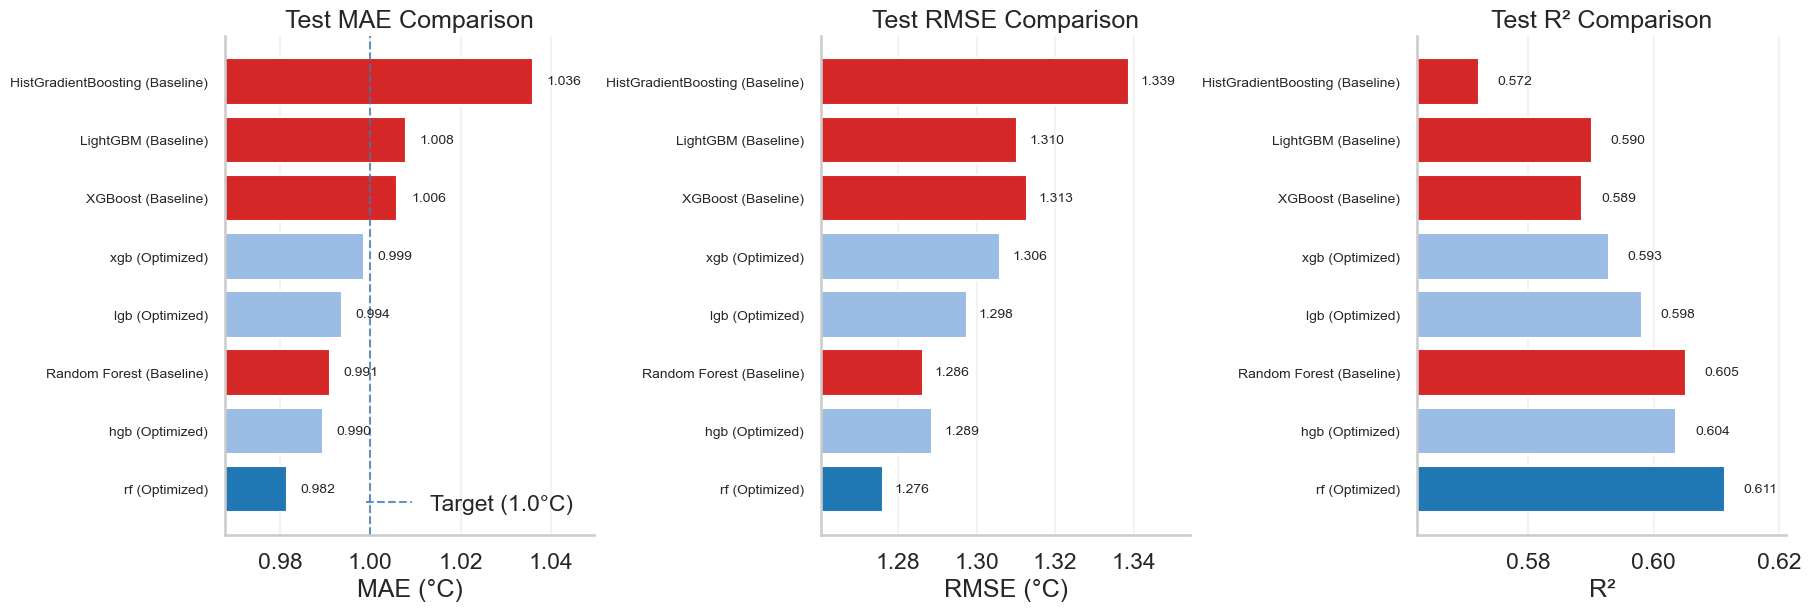

In [93]:
# Lấy dữ liệu từ comparison_df
models_list = comparison_df.index.tolist()
mae_values  = comparison_df['test_mae'].values
rmse_values = comparison_df['test_rmse'].values
r2_values   = comparison_df['test_r2'].values

# Hàm tô màu
def pick_colors(labels, best_idx):
    colors = []
    for i, m in enumerate(labels):
        if 'Baseline' in m:
            colors.append('#d62728')          # đỏ cho baseline
        elif i == best_idx:
            colors.append('#1f77b4')          # xanh đậm cho best
        else:
            colors.append('#9bbce5')          # xanh nhạt cho còn lại
    return colors

# Thứ tự hiển thị theo MAE tăng dần 
order = np.argsort(mae_values)
models_ord = [models_list[i] for i in order]
mae_ord    = mae_values[order]
rmse_ord   = rmse_values[order]
r2_ord     = r2_values[order]

# Vị trí tốt nhất trong từng metric
best_mae_pos  = int(np.argmin(mae_ord))
best_rmse_pos = int(np.argmin(rmse_ord))
best_r2_pos   = int(np.argmax(r2_ord))

# Hàm gắn nhãn giá trị lên cột 
def annotate_barh(ax, values, fmt="{:.3f}", dx=0.003):
    for rect, v in zip(ax.patches, values):
        x = rect.get_width()
        y = rect.get_y() + rect.get_height()/2
        ax.text(x + dx, y, fmt.format(v), va='center', fontsize=10)

# tạo 3 biểu đồ song song
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# MAE 
colors_mae = pick_colors(models_ord, best_mae_pos)
axes[0].barh(models_ord, mae_ord, color=colors_mae)
axes[0].axvline(1.0, linestyle='--', linewidth=1.5, label='Target (1.0°C)', color='#4477aa', alpha=0.8)

m0, M0 = mae_ord.min(), mae_ord.max()
margin = max(0.01, (M0 - m0) * 0.25)
axes[0].set_xlim(m0 - margin, M0 + margin)
axes[0].set_xlabel('MAE (°C)')
axes[0].set_title('Test MAE Comparison')
axes[0].grid(False)                    # tắt toàn bộ grid
axes[0].grid(axis='x', alpha=0.25)     # bật lại grid dọc nhẹ
axes[0].legend(loc='lower right', frameon=False)
annotate_barh(axes[0], mae_ord)

# RMSE 
colors_rmse = pick_colors(models_ord, best_rmse_pos)
axes[1].barh(models_ord, rmse_ord, color=colors_rmse)

m1, M1 = rmse_ord.min(), rmse_ord.max()
margin = max(0.015, (M1 - m1) * 0.25)
axes[1].set_xlim(m1 - margin, M1 + margin)
axes[1].set_xlabel('RMSE (°C)')
axes[1].set_title('Test RMSE Comparison')
axes[1].grid(False)
axes[1].grid(axis='x', alpha=0.25)
annotate_barh(axes[1], rmse_ord)

# R² 
colors_r2 = pick_colors(models_ord, best_r2_pos)
axes[2].barh(models_ord, r2_ord, color=colors_r2)

m2, M2 = r2_ord.min(), r2_ord.max()
margin = max(0.003, (M2 - m2) * 0.25)
axes[2].set_xlim(m2 - margin, M2 + margin)
axes[2].set_xlabel('R²')
axes[2].set_title('Test R² Comparison')
axes[2].grid(False)
axes[2].grid(axis='x', alpha=0.25)
annotate_barh(axes[2], r2_ord)

# Làm gọn: bỏ khung thừa, căn nhãn
for ax in axes:
    ax.spines[['top','right']].set_visible(False)
    ax.tick_params(axis='y', labelsize=10)

plt.show()

## 11.2 Performance Monitoring Summary and Visualization

In [153]:
# Performance Monitoring Dashboard và Visualization
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

def prepare_performance_df(performance_stats):
    """Chuẩn bị DataFrame từ performance_stats để dễ visualize"""
    data = []
    
    # Mapping model names và stages
    model_mapping = {
        'xgb': 'XGBoost',
        'rf': 'Random Forest',
        'lgb': 'LightGBM',
        'hgb': 'HistGradientBoosting'
    }
    
    stage_mapping = {
        'optimization': 'Optimization',
        'best_cv': 'Best Params CV',
        'final_training': 'Final Training',
        'test': 'Test Evaluation'
    }
    
    for key, stats in performance_stats.items():
        # Parse key: e.g., 'xgb_optimization' -> ('xgb', 'optimization')
        parts = key.split('_', 1)
        if len(parts) == 2:
            model_code, stage_code = parts
            
            model_name = model_mapping.get(model_code, model_code)
            stage_name = stage_mapping.get(stage_code, stage_code)
            
            data.append({
                'Model': model_name,
                'Stage': stage_name,
                'Time (seconds)': stats['seconds'],
                'Time (hours)': stats['seconds'] / 3600,
                'Time (minutes)': stats['seconds'] / 60,
                'Py-Peak (MB)': stats['py_peak_mb'],
                'RSS Before (MB)': stats['rss_before_mb'],
                'RSS After (MB)': stats['rss_after_mb'],
                'RSS Delta (MB)': stats['rss_delta_mb'],
                'Model_Code': model_code,
                'Stage_Code': stage_code
            })
    
    return pd.DataFrame(data)

# Tạo DataFrame
df_perf = prepare_performance_df(performance_stats)

print("Performance Data Summary:")
print(df_perf[['Model', 'Stage', 'Time (seconds)', 'Py-Peak (MB)', 'RSS Delta (MB)']].to_string(index=False))
print(f"\nTotal execution time: {df_perf['Time (seconds)'].sum() / 3600:.2f} hours")


Performance Data Summary:
               Model           Stage  Time (seconds)  Py-Peak (MB)  RSS Delta (MB)
             XGBoost    Optimization         2504.35          70.8          1950.9
             XGBoost  Best Params CV            9.96          26.1             3.5
             XGBoost  Final Training            0.06           0.3             3.7
             XGBoost Test Evaluation            0.00           0.2             0.0
       Random Forest    Optimization        35206.78          47.2           188.1
       Random Forest  Best Params CV          396.24          46.1           136.0
       Random Forest  Final Training           11.01          34.2           613.2
       Random Forest Test Evaluation            0.14           2.0             0.2
            LightGBM    Optimization         5565.90          88.1           540.7
            LightGBM  Best Params CV           17.52          26.3             5.6
            LightGBM  Final Training            0.11         

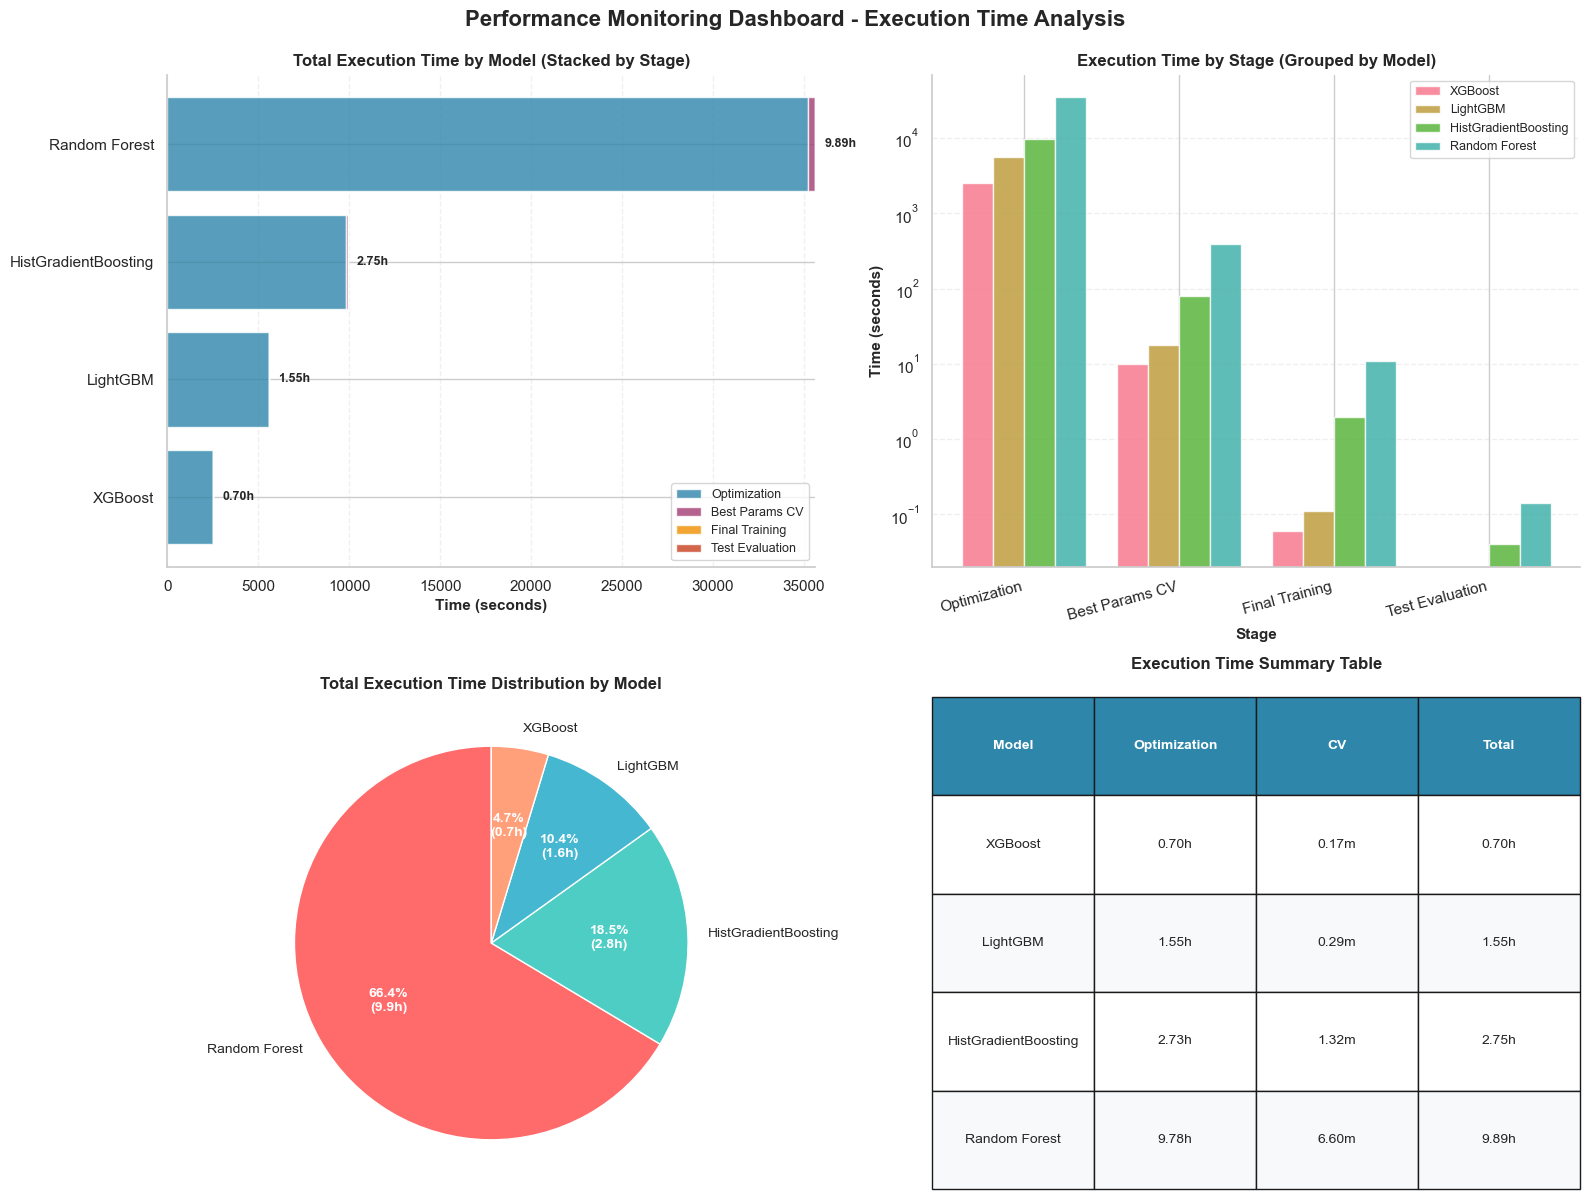

In [154]:
# 1. Bar Chart: Execution Time by Model and Stage
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Monitoring Dashboard - Execution Time Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

# Define colors and orders
stage_order = ['Optimization', 'Best Params CV', 'Final Training', 'Test Evaluation']
model_order = ['XGBoost', 'LightGBM', 'HistGradientBoosting', 'Random Forest']
colors_stage = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
colors_model = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# 1.1 Time by Stage (stacked bars)
ax1 = axes[0, 0]
bottom = np.zeros(len(model_order))
for i, stage in enumerate(stage_order):
    stage_times = []
    for model in model_order:
        val = df_perf[(df_perf['Model'] == model) & (df_perf['Stage'] == stage)]['Time (seconds)'].values
        stage_times.append(val[0] if len(val) > 0 else 0)
    
    ax1.barh(model_order, stage_times, left=bottom, label=stage, color=colors_stage[i], alpha=0.8)
    bottom += np.array(stage_times)

ax1.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
ax1.set_title('Total Execution Time by Model (Stacked by Stage)', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, model in enumerate(model_order):
    total_time = df_perf[df_perf['Model'] == model]['Time (seconds)'].sum()
    ax1.text(total_time + 500, i, f'{total_time/3600:.2f}h', 
             va='center', fontsize=9, fontweight='bold')

# 1.2 Time by Stage (grouped bars)
ax2 = axes[0, 1]
x = np.arange(len(stage_order))
width = 0.2
for i, model in enumerate(model_order):
    times = []
    for stage in stage_order:
        val = df_perf[(df_perf['Model'] == model) & (df_perf['Stage'] == stage)]['Time (seconds)'].values
        times.append(val[0] if len(val) > 0 else 0)
    ax2.bar(x + i * width, times, width, label=model, alpha=0.8)

ax2.set_xlabel('Stage', fontsize=11, fontweight='bold')
ax2.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax2.set_title('Execution Time by Stage (Grouped by Model)', fontsize=12, fontweight='bold')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels(stage_order, rotation=15, ha='right')
ax2.legend(fontsize=9)
ax2.set_yscale('log')  # Log scale vì optimization time rất lớn
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.spines[['top', 'right']].set_visible(False)

# 1.3 Pie Chart: Total Time by Model
ax3 = axes[1, 0]
model_totals = df_perf.groupby('Model')['Time (seconds)'].sum().sort_values(ascending=False)
wedges, texts, autotexts = ax3.pie(model_totals.values, labels=model_totals.index, 
                                    autopct='%1.1f%%', colors=colors_model, 
                                    startangle=90, textprops={'fontsize': 10})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    # Thêm hours vào label
    idx = autotexts.index(autotext)
    percent = model_totals.values[idx] / model_totals.sum() * 100
    hours = model_totals.values[idx] / 3600
    autotext.set_text(f'{percent:.1f}%\n({hours:.1f}h)')

ax3.set_title('Total Execution Time Distribution by Model', fontsize=12, fontweight='bold')

# 1.4 Time breakdown table
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary table
table_data = []
for model in model_order:
    model_df = df_perf[df_perf['Model'] == model]
    opt_time = model_df[model_df['Stage'] == 'Optimization']['Time (seconds)'].values[0] if len(model_df[model_df['Stage'] == 'Optimization']) > 0 else 0
    cv_time = model_df[model_df['Stage'] == 'Best Params CV']['Time (seconds)'].values[0] if len(model_df[model_df['Stage'] == 'Best Params CV']) > 0 else 0
    total_time = model_df['Time (seconds)'].sum()
    
    table_data.append([
        model,
        f"{opt_time/3600:.2f}h",
        f"{cv_time/60:.2f}m",
        f"{total_time/3600:.2f}h"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Model', 'Optimization', 'CV', 'Total'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style table
for i in range(len(table_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#2E86AB')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#F8F9FA' if i % 2 == 0 else 'white')

ax4.set_title('Execution Time Summary Table', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


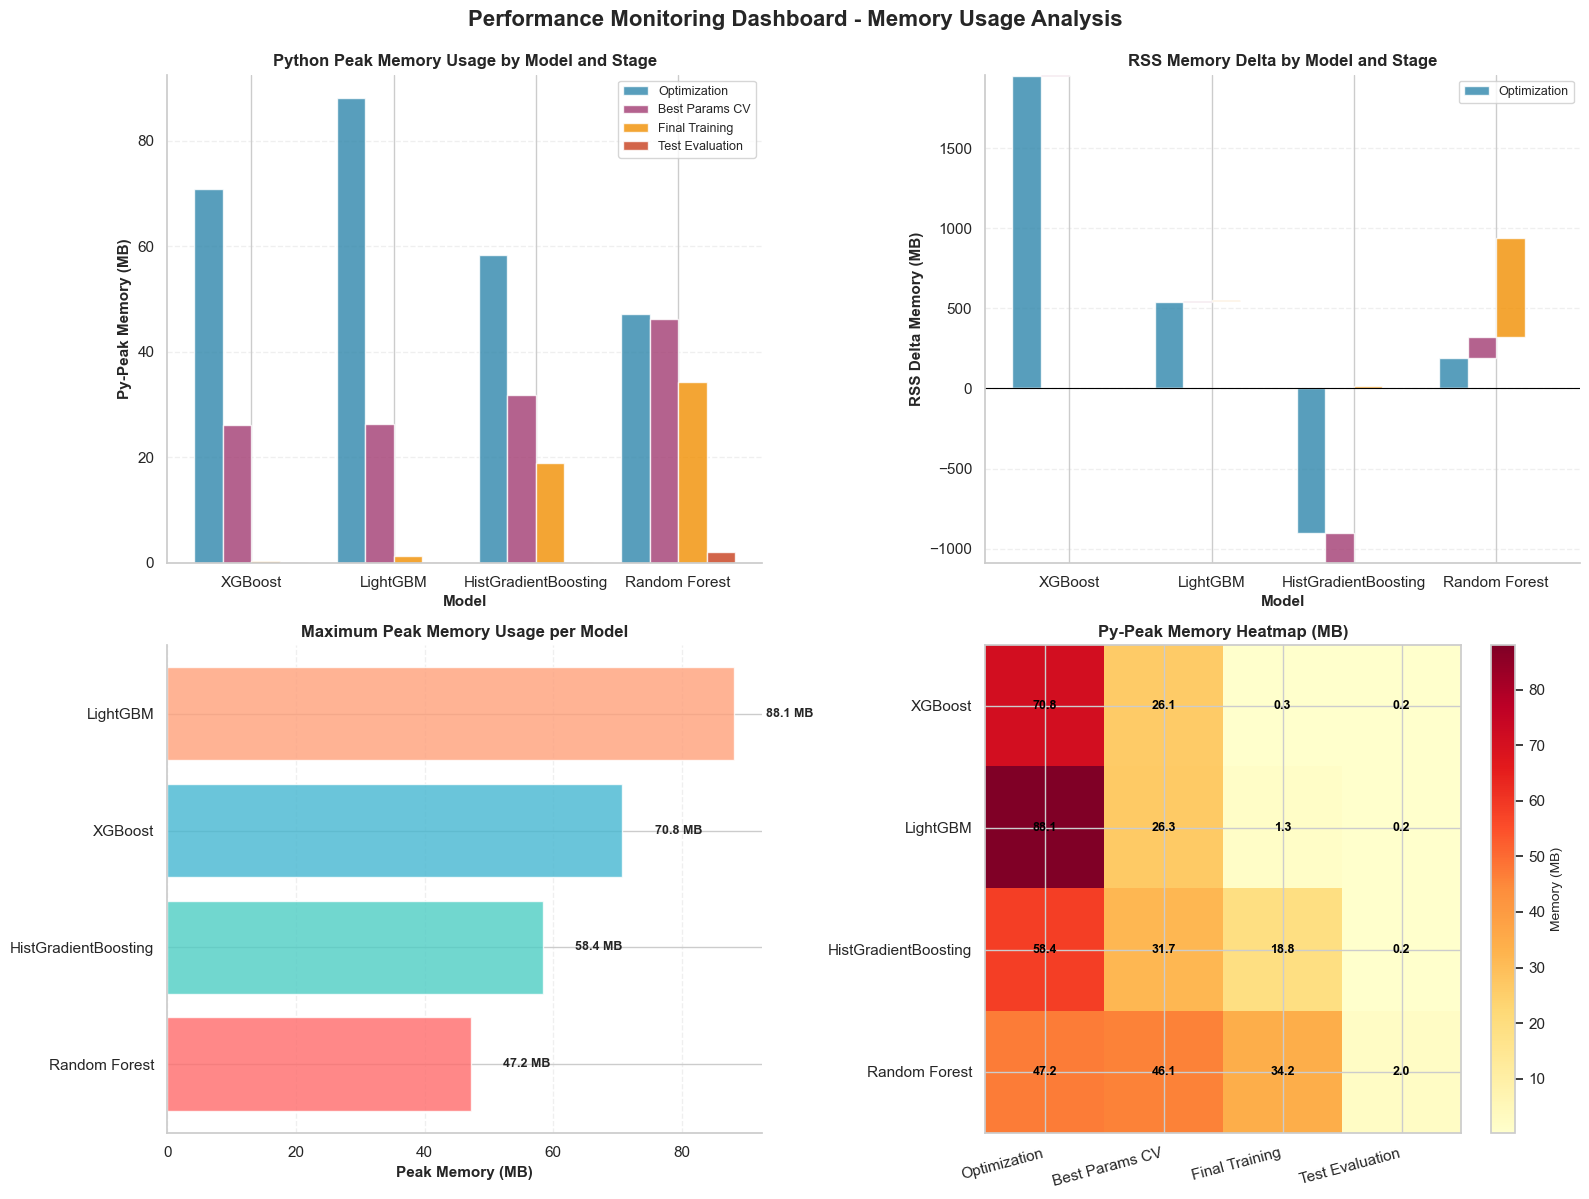

In [155]:
# 2. Memory Usage Analysis
# Define colors and orders (redefine to ensure they exist)
stage_order = ['Optimization', 'Best Params CV', 'Final Training', 'Test Evaluation']
model_order = ['XGBoost', 'LightGBM', 'HistGradientBoosting', 'Random Forest']
colors_stage = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
colors_model = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Monitoring Dashboard - Memory Usage Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

# 2.1 Py-Peak Memory by Model and Stage
ax1 = axes[0, 0]
pivot_py = df_perf.pivot(index='Model', columns='Stage', values='Py-Peak (MB)')[stage_order]
pivot_py = pivot_py.reindex(model_order)

x = np.arange(len(model_order))
width = 0.2
for i, stage in enumerate(stage_order):
    ax1.bar(x + i * width, pivot_py[stage].values, width, label=stage, 
            color=colors_stage[i], alpha=0.8)

ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
ax1.set_ylabel('Py-Peak Memory (MB)', fontsize=11, fontweight='bold')
ax1.set_title('Python Peak Memory Usage by Model and Stage', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(model_order)
ax1.legend(fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines[['top', 'right']].set_visible(False)

# 2.2 RSS Delta Memory by Model and Stage
ax2 = axes[0, 1]
pivot_rss = df_perf.pivot(index='Model', columns='Stage', values='RSS Delta (MB)')[stage_order]
pivot_rss = pivot_rss.reindex(model_order)

# Note: HGB có RSS delta âm (memory được giải phóng), nên cần xử lý
bottom_positive = np.zeros(len(model_order))
bottom_negative = np.zeros(len(model_order))

for i, stage in enumerate(stage_order):
    values = pivot_rss[stage].values
    positive = np.where(values >= 0, values, 0)
    negative = np.where(values < 0, values, 0)
    
    ax2.bar(x + i * width, positive, width, bottom=bottom_positive, 
            label=stage if i == 0 else "", color=colors_stage[i], alpha=0.8)
    ax2.bar(x + i * width, negative, width, bottom=bottom_negative, 
            color=colors_stage[i], alpha=0.8)
    
    bottom_positive += positive
    bottom_negative += negative

ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('RSS Delta Memory (MB)', fontsize=11, fontweight='bold')
ax2.set_title('RSS Memory Delta by Model and Stage', fontsize=12, fontweight='bold')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels(model_order)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.spines[['top', 'right']].set_visible(False)

# 2.3 Peak Memory Comparison (horizontal bar)
ax3 = axes[1, 0]
max_memory_by_model = df_perf.groupby('Model')['Py-Peak (MB)'].max().sort_values(ascending=True)
bars = ax3.barh(max_memory_by_model.index, max_memory_by_model.values, 
                color=colors_model, alpha=0.8)
ax3.set_xlabel('Peak Memory (MB)', fontsize=11, fontweight='bold')
ax3.set_title('Maximum Peak Memory Usage per Model', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, (model, value) in enumerate(max_memory_by_model.items()):
    ax3.text(value + 5, i, f'{value:.1f} MB', va='center', fontsize=9, fontweight='bold')

# 2.4 Memory Heatmap
ax4 = axes[1, 1]
# Create heatmap data: Model x Stage for Py-Peak Memory
heatmap_data = pivot_py.values
im = ax4.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')

# Set ticks
ax4.set_xticks(np.arange(len(stage_order)))
ax4.set_yticks(np.arange(len(model_order)))
ax4.set_xticklabels(stage_order, rotation=15, ha='right')
ax4.set_yticklabels(model_order)

# Add text annotations
for i in range(len(model_order)):
    for j in range(len(stage_order)):
        text = ax4.text(j, i, f'{heatmap_data[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

ax4.set_title('Py-Peak Memory Heatmap (MB)', fontsize=12, fontweight='bold')
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Memory (MB)', fontsize=10)

plt.tight_layout()
plt.show()


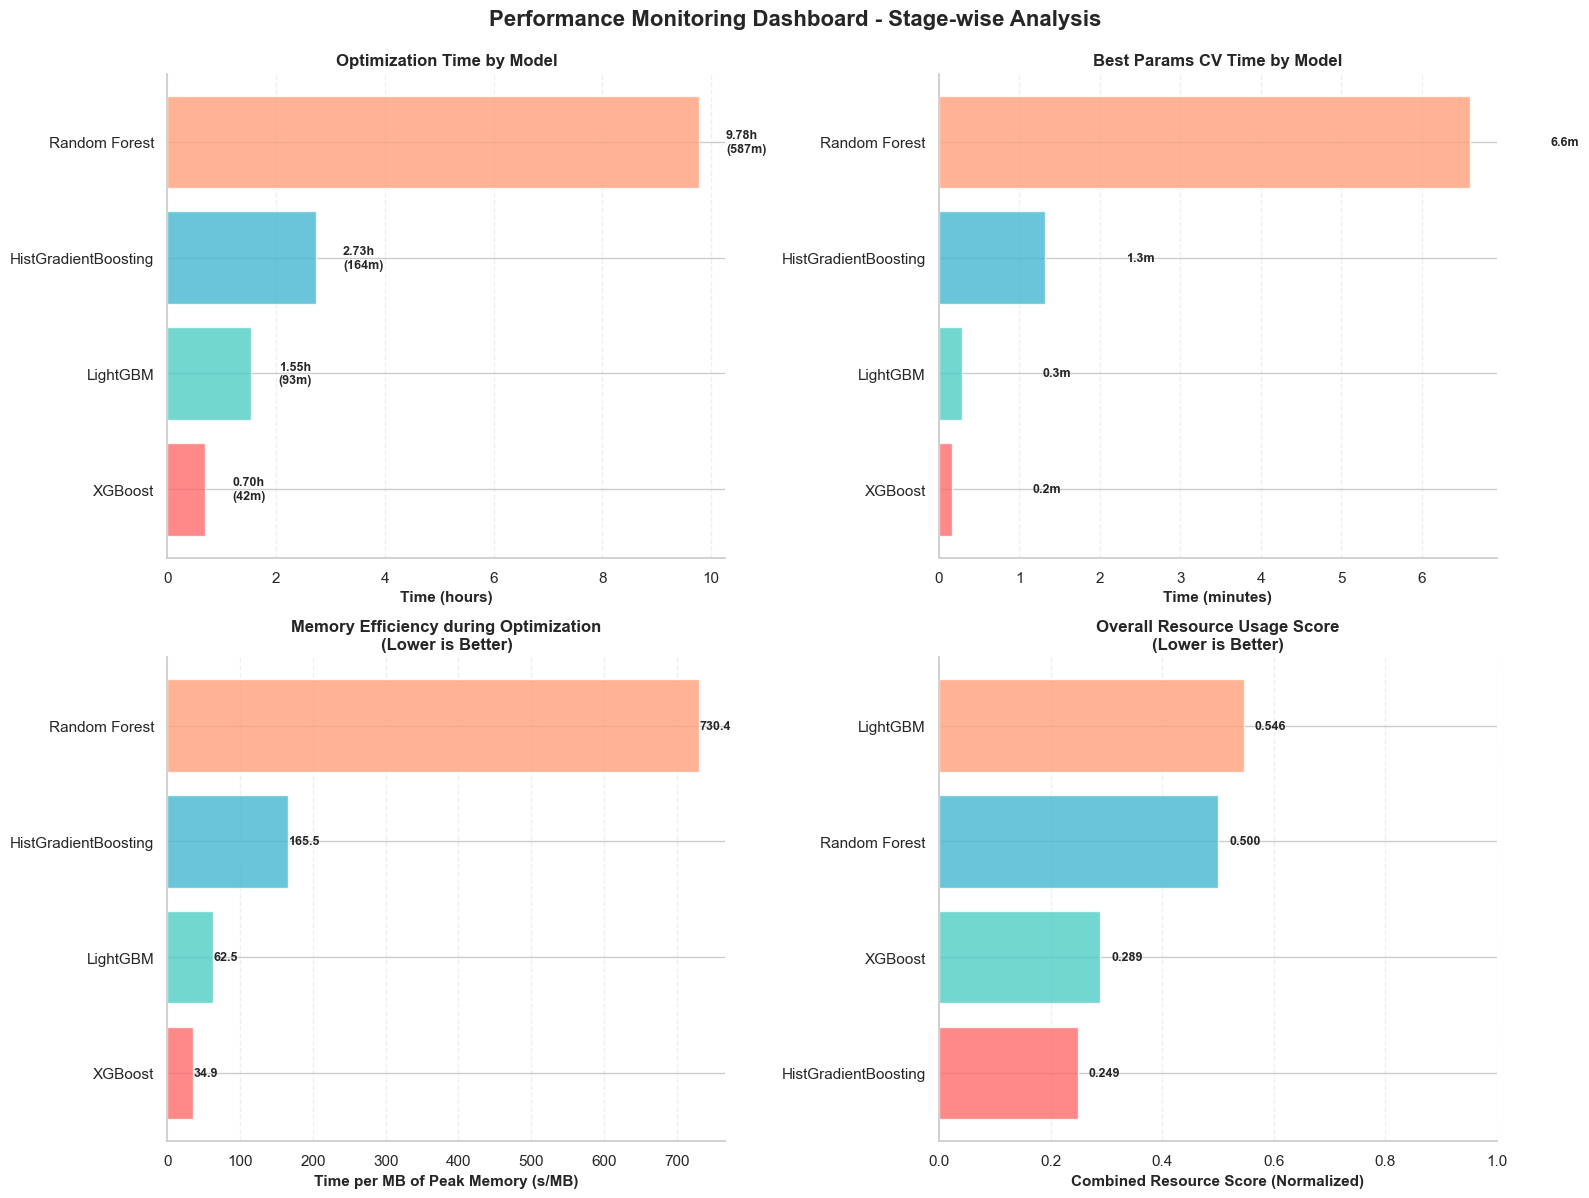

In [156]:
# 4. Stage-wise Performance Comparison
# Define colors and orders (redefine to ensure they exist)
stage_order = ['Optimization', 'Best Params CV', 'Final Training', 'Test Evaluation']
model_order = ['XGBoost', 'LightGBM', 'HistGradientBoosting', 'Random Forest']
colors_model = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Monitoring Dashboard - Stage-wise Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

# 4.1 Optimization Stage Comparison
ax1 = axes[0, 0]
opt_df = df_perf[df_perf['Stage'] == 'Optimization'].sort_values('Time (hours)', ascending=True)
bars1 = ax1.barh(opt_df['Model'], opt_df['Time (hours)'], color=colors_model, alpha=0.8)
ax1.set_xlabel('Time (hours)', fontsize=11, fontweight='bold')
ax1.set_title('Optimization Time by Model', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, (idx, row) in enumerate(opt_df.iterrows()):
    hours = row['Time (hours)']
    minutes = row['Time (minutes)']
    ax1.text(hours + 0.5, i, f'{hours:.2f}h\n({minutes:.0f}m)', 
             va='center', fontsize=9, fontweight='bold')

# 4.2 Best Params CV Stage Comparison
ax2 = axes[0, 1]
cv_df = df_perf[df_perf['Stage'] == 'Best Params CV'].sort_values('Time (minutes)', ascending=True)
bars2 = ax2.barh(cv_df['Model'], cv_df['Time (minutes)'], color=colors_model, alpha=0.8)
ax2.set_xlabel('Time (minutes)', fontsize=11, fontweight='bold')
ax2.set_title('Best Params CV Time by Model', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, (idx, row) in enumerate(cv_df.iterrows()):
    minutes = row['Time (minutes)']
    ax2.text(minutes + 1, i, f'{minutes:.1f}m', 
             va='center', fontsize=9, fontweight='bold')

# 4.3 Memory Efficiency (Time per MB of Peak Memory)
ax3 = axes[1, 0]
# Calculate efficiency: seconds per MB of peak memory
df_perf['Efficiency'] = df_perf['Time (seconds)'] / (df_perf['Py-Peak (MB)'] + 1)  # +1 to avoid division by zero
opt_efficiency = df_perf[df_perf['Stage'] == 'Optimization'].sort_values('Efficiency', ascending=True)

bars3 = ax3.barh(opt_efficiency['Model'], opt_efficiency['Efficiency'], 
                 color=colors_model, alpha=0.8)
ax3.set_xlabel('Time per MB of Peak Memory (s/MB)', fontsize=11, fontweight='bold')
ax3.set_title('Memory Efficiency during Optimization\n(Lower is Better)', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, (idx, row) in enumerate(opt_efficiency.iterrows()):
    eff = row['Efficiency']
    ax3.text(eff + 0.5, i, f'{eff:.1f}', 
             va='center', fontsize=9, fontweight='bold')

# 4.4 Total Resource Usage (Time + Memory)
ax4 = axes[1, 1]
# Combine normalized time and memory for overall resource usage
model_summary = df_perf.groupby('Model').agg({
    'Time (hours)': 'sum',
    'Py-Peak (MB)': 'max',
    'RSS Delta (MB)': lambda x: x.abs().sum()  # Absolute sum of RSS deltas
}).sort_values('Time (hours)', ascending=True)

# Normalize and combine
time_norm = (model_summary['Time (hours)'] - model_summary['Time (hours)'].min()) / \
            (model_summary['Time (hours)'].max() - model_summary['Time (hours)'].min())
memory_norm = (model_summary['Py-Peak (MB)'] - model_summary['Py-Peak (MB)'].min()) / \
              (model_summary['Py-Peak (MB)'].max() - model_summary['Py-Peak (MB)'].min())

# Combined score (average of normalized time and memory)
combined_score = (time_norm + memory_norm) / 2
combined_score = combined_score.sort_values(ascending=True)

bars4 = ax4.barh(combined_score.index, combined_score.values, 
                 color=colors_model, alpha=0.8)
ax4.set_xlabel('Combined Resource Score (Normalized)', fontsize=11, fontweight='bold')
ax4.set_title('Overall Resource Usage Score\n(Lower is Better)', fontsize=12, fontweight='bold')
ax4.set_xlim(0, 1)
ax4.grid(axis='x', alpha=0.3, linestyle='--')
ax4.spines[['top', 'right']].set_visible(False)

# Add value labels
for i, (model, score) in enumerate(combined_score.items()):
    ax4.text(score + 0.02, i, f'{score:.3f}', 
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Save Performance Summary Report
import json
from datetime import datetime

# Define model order (redefine to ensure it exists)
model_order = ['XGBoost', 'LightGBM', 'HistGradientBoosting', 'Random Forest']

# Create summary report
performance_summary = {
    'generated_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_execution_time_hours': df_perf['Time (seconds)'].sum() / 3600,
    'models': {}
}

for model in model_order:
    model_df = df_perf[df_perf['Model'] == model]
    performance_summary['models'][model] = {
        'total_time_hours': model_df['Time (seconds)'].sum() / 3600,
        'optimization_time_hours': model_df[model_df['Stage'] == 'Optimization']['Time (seconds)'].values[0] / 3600,
        'cv_time_minutes': model_df[model_df['Stage'] == 'Best Params CV']['Time (seconds)'].values[0] / 60,
        'max_peak_memory_mb': model_df['Py-Peak (MB)'].max(),
        'total_rss_delta_mb': model_df['RSS Delta (MB)'].sum()
    }

# Save to JSON
summary_path = '../results/performance_monitoring_summary.json'
os.makedirs(os.path.dirname(summary_path), exist_ok=True)
with open(summary_path, 'w') as f:
    json.dump(performance_summary, f, indent=2)

print(f"Performance summary saved to: {summary_path}")
print(f"\nQuick Summary:")
print(f"   Total Execution Time: {performance_summary['total_execution_time_hours']:.2f} hours")
print(f"\n   Per Model Breakdown:")
for model, stats in performance_summary['models'].items():
    print(f"   {model:20s}: {stats['total_time_hours']:6.2f}h total | "
          f"{stats['optimization_time_hours']:6.2f}h opt | "
          f"{stats['max_peak_memory_mb']:6.1f} MB peak")

# Save DataFrame to CSV
csv_path = '../results/performance_monitoring_detailed.csv'
df_perf.to_csv(csv_path, index=False)
print(f"Detailed performance data saved to: {csv_path}")


Performance summary saved to: ../results/performance_monitoring_summary.json

Quick Summary:
   Total Execution Time: 14.90 hours

   Per Model Breakdown:
   XGBoost             :   0.70h total |   0.70h opt |   70.8 MB peak
   LightGBM            :   1.55h total |   1.55h opt |   88.1 MB peak
   HistGradientBoosting:   2.75h total |   2.73h opt |   58.4 MB peak
   Random Forest       :   9.89h total |   9.78h opt |   47.2 MB peak
Detailed performance data saved to: ../results/performance_monitoring_detailed.csv


# 12. Save Optimized Model

In [159]:
import joblib
import os
import json
from datetime import datetime

# Create models directory
models_dir = '../artifacts'
os.makedirs(models_dir, exist_ok=True)

# Model metadata mapping
model_study_map = {
    'xgb': ('XGBoost', xgb_study if 'xgb_study' in globals() else None),
    'rf': ('RandomForest', rf_study if 'rf_study' in globals() else None),
    'lgb': ('LightGBM', lgb_study if 'lgb_study' in globals() else None),
    'hgb': ('HistGradientBoosting', hgb_study if 'hgb_study' in globals() else None)
}

# Function để save một model
def save_model_with_metadata(model_key, model, model_display_name, study, models_dir, timestamp):
    """Save model và metadata"""
    
    # Save model
    model_filename = f"{model_key}_optimized_{timestamp}.joblib"
    model_path = os.path.join(models_dir, model_filename)
    joblib.dump(model, model_path)
    
    # Prepare metadata
    metadata = {
        'model_type': model_display_name,
        'model_key': model_key,
        'optimization_method': 'Optuna',
        'best_params': study.best_params if study else {},
        'cv_mae': study.best_value if study else None,
        'features': list(X_train.columns) if 'X_train' in globals() else [],
        'training_samples': len(X_tv) if 'X_tv' in globals() else 0,
        'test_samples': len(X_test) if 'X_test' in globals() else 0,
        'created_at': timestamp,
        'seed': SEED
    }
    
    # Add test results if available
    if 'all_test_results' in globals() and model_key in all_test_results:
        metadata.update({
            'test_mae': all_test_results[model_key]['test_mae'],
            'test_rmse': all_test_results[model_key]['test_rmse'],
            'test_r2': all_test_results[model_key]['test_r2']
        })
    
    # Save metadata
    metadata_filename = f"{model_key}_optimized_metadata_{timestamp}.json"
    metadata_path = os.path.join(models_dir, metadata_filename)
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return model_path, metadata_path, metadata

# Save tất cả models
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
saved_models = {}

  
print("SAVING ALL OPTIMIZED MODELS")
  

for model_key, model in final_models.items():
    if model_key in model_study_map:
        model_display_name, study = model_study_map[model_key]
        
        try:
            model_path, metadata_path, metadata = save_model_with_metadata(
                model_key, model, model_display_name, study, models_dir, timestamp
            )
            
            saved_models[model_key] = {
                'path': model_path,
                'metadata_path': metadata_path,
                'metadata': metadata
            }
            
            test_info = ""
            if 'all_test_results' in globals() and model_key in all_test_results:
                test_mae = all_test_results[model_key]['test_mae']
                test_info = f" | Test MAE: {test_mae:.4f}°C"
            
            cv_mae = study.best_value if study else "N/A"
            print(f"  {model_display_name:25s} | CV MAE: {cv_mae:.4f}°C{test_info}")
            
        except Exception as e:
            print(f"   {model_display_name:25s} | Error: {e}")

print(f"\nSaved {len(saved_models)} models to: {models_dir}")

print("MODEL SUMMARY")

# Sort by test MAE if available
if 'all_test_results' in globals():
    sorted_models = sorted(
        saved_models.items(),
        key=lambda x: all_test_results[x[0]]['test_mae'] if x[0] in all_test_results else float('inf')
    )
else:
    sorted_models = list(saved_models.items())

for i, (model_key, info) in enumerate(sorted_models, 1):
    model_display_name = model_study_map[model_key][0]
    metadata = info['metadata']
    
    print(f"\n{i}. {model_display_name} ({model_key})")
    print(f"   File: {os.path.basename(info['path'])}")
    
    if 'cv_mae' in metadata and metadata['cv_mae'] is not None:
        print(f"   CV MAE: {metadata['cv_mae']:.4f}°C")
    
    if 'test_mae' in metadata:
        print(f"   Test MAE: {metadata['test_mae']:.4f}°C")
        print(f"   Test RMSE: {metadata['test_rmse']:.4f}°C")
        print(f"   Test R²: {metadata['test_r2']:.4f}")
    
    if 'best_params' in metadata:
        print(f"   Parameters: {len(metadata['best_params'])} hyperparameters")

# Find and highlight best model
if 'all_test_results' in globals():
    best_model_key = min(all_test_results.keys(), key=lambda k: all_test_results[k]['test_mae'])
    best_model_name = model_study_map[best_model_key][0]
    best_test_mae = all_test_results[best_model_key]['test_mae']
    
    print("BEST MODEL (Lowest Test MAE):")
    print(f"   Model: {best_model_name} ({best_model_key})")
    print(f"   Test MAE: {best_test_mae:.4f}°C")
    print(f"   File: {os.path.basename(saved_models[best_model_key]['path'])}")
      

# Save summary JSON với info tất cả models
summary_path = os.path.join(models_dir, f"all_models_summary_{timestamp}.json")
summary_data = {
    'timestamp': timestamp,
    'models_saved': len(saved_models),
    'best_model': best_model_key if 'all_test_results' in globals() else None,
    'models': {
        k: {
            'model_file': os.path.basename(v['path']),
            'metadata_file': os.path.basename(v['metadata_path']),
            'test_mae': v['metadata'].get('test_mae'),
            'cv_mae': v['metadata'].get('cv_mae')
        }
        for k, v in saved_models.items()
    }
}
with open(summary_path, 'w') as f:
    json.dump(summary_data, f, indent=2)
print(f"Summary saved to: {summary_path}")

SAVING ALL OPTIMIZED MODELS
  XGBoost                   | CV MAE: 0.8851°C | Test MAE: 0.9986°C
  LightGBM                  | CV MAE: 0.8873°C | Test MAE: 0.9938°C
  HistGradientBoosting      | CV MAE: 0.9379°C | Test MAE: 0.9896°C
  RandomForest              | CV MAE: 0.9457°C | Test MAE: 0.9815°C

Saved 4 models to: ../artifacts
MODEL SUMMARY

1. RandomForest (rf)
   File: rf_optimized_20251102_163703.joblib
   CV MAE: 0.9457°C
   Test MAE: 0.9815°C
   Test RMSE: 1.2761°C
   Test R²: 0.6113
   Parameters: 6 hyperparameters

2. HistGradientBoosting (hgb)
   File: hgb_optimized_20251102_163703.joblib
   CV MAE: 0.9379°C
   Test MAE: 0.9896°C
   Test RMSE: 1.2887°C
   Test R²: 0.6036
   Parameters: 7 hyperparameters

3. LightGBM (lgb)
   File: lgb_optimized_20251102_163703.joblib
   CV MAE: 0.8873°C
   Test MAE: 0.9938°C
   Test RMSE: 1.2976°C
   Test R²: 0.5981
   Parameters: 10 hyperparameters

4. XGBoost (xgb)
   File: xgb_optimized_20251102_163703.joblib
   CV MAE: 0.8851°C
   Test 